# Introduction

This report will analyse the following filter, creating a bode plot, analysing it's step response and comparing to simulations made in LT-spice.

![Circuit Diagram of filter](assets/images/circuit.png)

# Transfer function

The transfer function of an LTI-system describes the relationship between the input and output of the system. Finding it is the first step in describing the circuit. We will do this by using the impedence $Z$. 

## Impedence 

Inorder to easily find the transfer function we will define a property called *impedence* for each of our components. We define it as: $$Z = \frac{u}{i}$$

and proceed to find this property for each of our components.

### Resistor

The impedence of the resistor can be found using Ohm's law:

$$u = R \cdot i \Leftrightarrow Z = \frac{u}{i} = R$$

### Capacitor

The capacitors can also be found by a similar method, using the definition of capacitance:

$$Q = C \cdot U \Rightarrow i(t) = C \cdot \frac{d u(t)}{dt}$$

$$\Leftrightarrow du(t) = \frac{1}{C} \cdot i(t) \, dt$$

$$\Leftrightarrow u(t) = \frac{1}{C} \cdot \int_0^t i(t) \, dt$$

Laplace-transforming this we get:

$$U(s) = \frac{1}{C} \cdot s^-1 \cdot I(s) + \frac{u(0)}{sC}$$

**Assumption:** at time t=0 the transistor is uncharged, therefore $u(0) = 0$ V.

$$\Rightarrow Z = \frac{U(s)}{I(s)} = \frac{1}{sC}$$

### Inductor

The potential drop over a pure inductor is:

$$u(t) = L \frac{di(t)}{dt}$$

If we apply the Laplace transform to this we get:

$$\Rightarrow U(s) = L \mathscr{L}\left[\frac{di}{dt}\right](s) = L(sI(s)-i(0))$$

at time t=0 the conductor must be 0 because the inductor doesn't have a magnetic field before current goes through it. Therefore:

$$U(s) = sLI(s) \Leftrightarrow Z(s) = \frac{U(s)}{I(s)} = sL$$

## Derivation

Using voltage division we find that:

$$u_1 = u_0 \cdot \frac{Z_R}{Z_C || Z_L + Z_R}$$

To make our life easier, let's first simplify our parallel replacement resistance $Z_C || Z_L$:

$$\Rightarrow Z_C || Z_L = \left( sC + \frac{1}{sL} \right)^{-1} = \frac{sL}{s^2CL + 1}$$

Now inserting (Note: $Z_R = R$):

$$\Rightarrow \frac{u_1}{u_0} = \frac{R}{\frac{sL}{s^2CL + 1} + R} = \frac{R}{\frac{sL + R(s^2CL+1)}{s^2CL + 1}} = \frac{R(s^2CL + 1)}{R(s^2CL + 1) + sL} = H(s)$$

This is our transfer function, using it we can describe our LTI system.

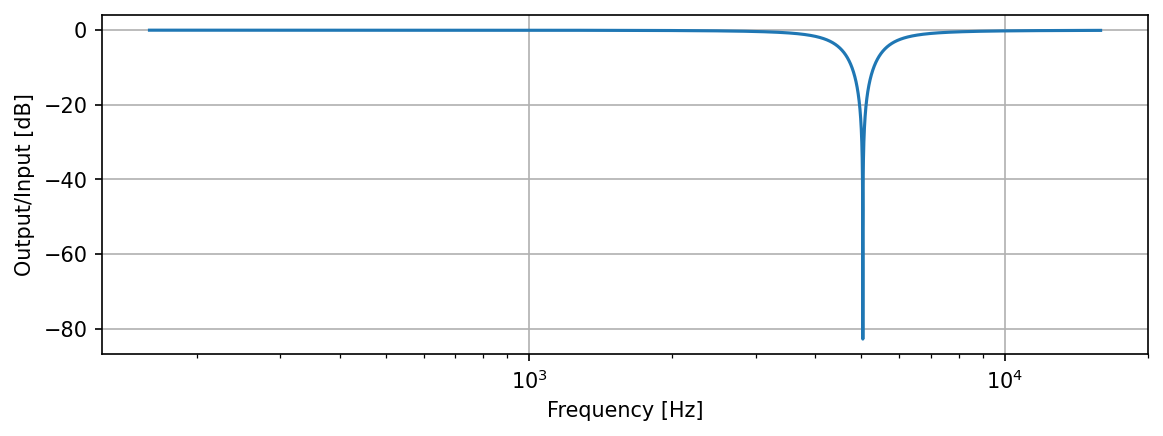

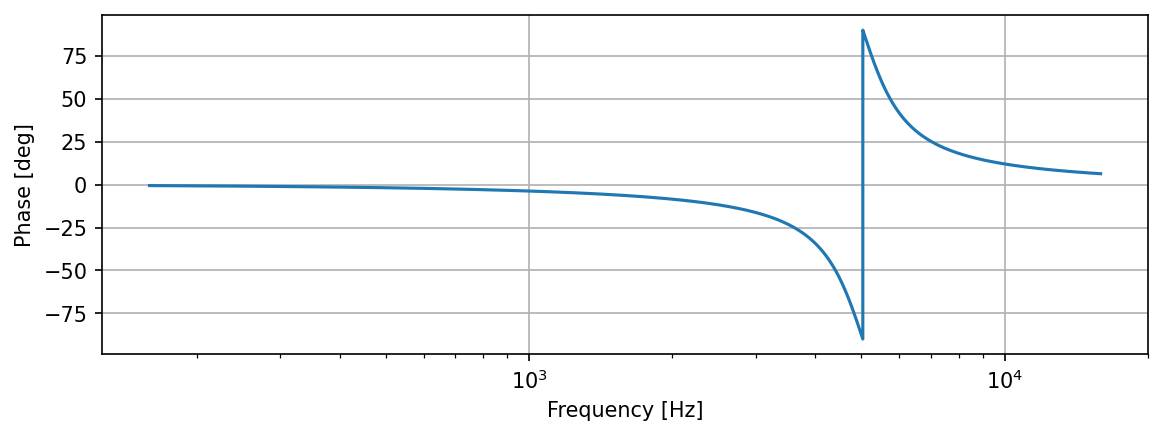

In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)

w, mag, phase = signal.bode(LTI,n=100000)

# Convert rad/s to Hz
f=w/(2*np.pi)

plt.figure(figsize=(9, 3), dpi=150)
plt.semilogx(f,mag)
#plt.hlines(-3,min(f),max(f),linestyles="dotted",colors='r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Output/Input [dB]')
plt.grid()
plt.figure(figsize=(9, 3), dpi=150)
plt.semilogx(f, phase)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()
plt.show()

# Step response

Let's now explore how our filter responds to a stepsignal. This will be done numerically using the python library SciPy and analytically using our transferfunction.

## Numerical calculation

SciPy has a function called *step* which can be used to calculate the step response of an LTI-system given the systems transferfunction. The function uses 

This report will compute the step response numerically for 10000 points. 

## Finding analytical expression

For an LTI-system the output $y(t)$ is calculated by taking the convolution of the impulse response $h(t) = \mathscr{L}^{-1}[H](t)$, where $H(s)$ is the transfer function, with the input $x(t)$:

$$y(t) = x * h (t) = \int_0^\infty x(u)h(t-u) \, du $$

To find the step response, $\varphi(t)$, we will use the heaviside function, $\theta(t)$, as our input. And since we don't know the impulse response of our system and finding it seems very difficult to calculate we will begin by Laplace transforming:

$$\Rightarrow \mathscr{L}[y](s) = Y(s) = \mathscr{L}[\theta](s) \cdot H(s) = \frac{1}{s} \cdot \frac{R(s^2CL + 1)}{R(s^2CL + 1) + sL}$$

To find y(t) is the inverse laplace tansform of this, to find it we first need to use partial breaking: 

$$\frac{R(s^2CL + 1)}{s(R(s^2CL + 1) + sL)} = \frac{Xs + Y}{RCLs^2+Ls+R} + \frac{Z}{s}\\
\Leftrightarrow s\cdot(Xs + Y) + (RCLs^2+LS+R)\cdot Z\\
\Rightarrow \left\{\begin{array}{l}
    RCL = X+Z \cdot RCL\\
    0 = Y+ZL\\
    R = ZR 
    \end{array}\right. 
\Rightarrow \left\{\begin{array}{l}
    X = 0 \\
    Y = -L\\
    Z = 1  
    \end{array}\right. \\
\Rightarrow \frac{R(s^2CL + 1)}{R(s^2CL + 1) + sL} = \frac{1}{s} - \frac{L}{RCLs^2+Ls+R}
    $$

The inverse laplace of the first term is simply:

$$\mathscr{L}^{-1}\left[\frac{1}{s}\right](t) = \theta(t)$$

the second term is a little more complicated:

$$\mathscr{L}^{-1}\left[ \frac{1}{RCLs^2Ls+R}\right] = \frac{1}{RCL} \mathscr{L}^{-1}\left[ \left(s^2+ \frac{s}{RC}+\frac{1}{CL}\right)^{-1}\right] (t)\\
= \frac{1}{RCL} \mathscr{L}^{-1} \left[ \left(\left( s+\frac{1}{2RC}\right)^2 - \frac{1}{2RC} + \frac{1}{CL}\right)^{-1}\right] (t)$$

There is a well established rule for the laplace transform which says:

$$ \mathscr{L}\left[ e^{at} f(t)\right] = \frac{1}{a}F(s/a)\\ 
\Rightarrow \frac{1}{RCL} \mathscr{L}^{-1} \left[ \left(\left( s+\frac{1}{2RC}\right)^2 - \frac{1}{2RC} + \frac{1}{CL}\right)^{-1}\right] (t) = \frac{e^{at}}{RCL} \mathscr{L}^{-1} \left[ \left(s^2 - \frac{1}{2RC} + \frac{1}{CL}\right)^{-1}\right] (t)$$

If we define $b^2 = \frac{1}{CL} - \frac{1}{2RC}$ we can use the rule for the laplace transform of sine:

$$\Rightarrow \frac{e^{at}}{RCL} \mathscr{L}^{-1} \left[ \left(s^2 - \frac{1}{2RC} + \frac{1}{CL}\right)^{-1}\right] (t) = \frac{e^{at}}{RCL} \mathscr{L}^{-1} \left[ \left(s^2 + b^2\right)^{-1}\right] (t)\\
=\frac{e^{at}}{RCL} \mathscr{L}^{-1} \left[ \frac{b}{b(s^2 + b^2)}\right] (t) = \frac{e^{at}}{RCL \cdot b} \sin{bt}\\
=\frac{e^{at}}{RCL \sqrt{\frac{1}{CL} - \frac{1}{4R^2 C^2}}} \sin{\left( t \cdot \sqrt{\frac{1}{CL} - \frac{1}{4R^2 C^2}}\right)}$$

Inserting this into our expression for $\varphi(t)$ from before we get:

$$\varphi(t) = \theta(t) - \frac{L \cdot e^{at}}{RCL \sqrt{\frac{1}{CL} - \frac{1}{4R^2 C^2}}} \sin{\left( t \cdot \sqrt{\frac{1}{CL} - \frac{1}{4R^2 C^2}}\right)}$$

Or for $t \geq 0$:
$$\varphi(t) = 1 - \frac{L \cdot e^{at}}{RCL \sqrt{\frac{1}{CL} - \frac{1}{4R^2 C^2}}} \sin{\left( t \cdot \sqrt{\frac{1}{CL} - \frac{1}{4R^2 C^2}}\right)}$$





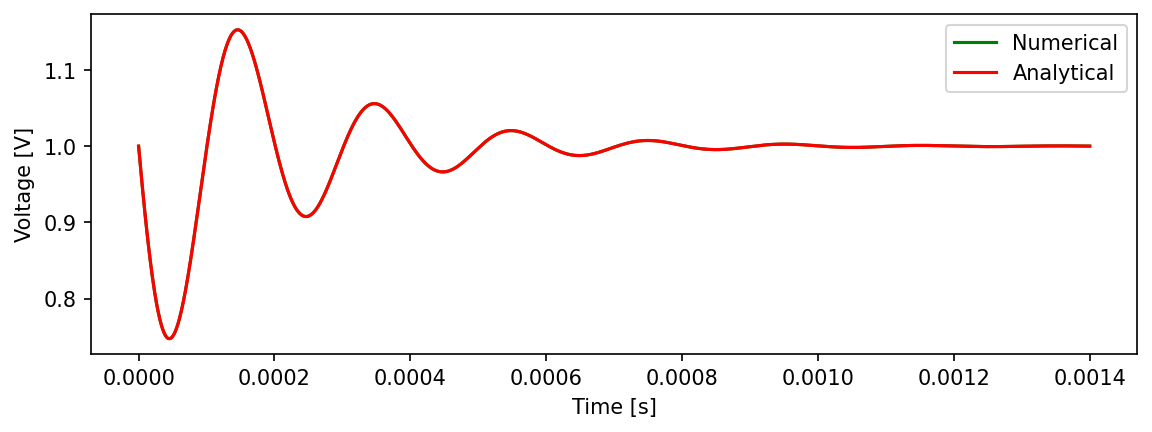

In [4]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
# Component values
R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)
# Transfer function
numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)
tDataLTI, yDataLTI = signal.step(LTI, N = 10000)

# Analytical expression
a = - 1 / (2*R*C)
b = np.sqrt(1/(C*L) - 1/(4* R**2 * C**2))
c = b * R*C*L

calcResponse = lambda t : 1 - L / (c) * np.exp(t*a) * np.sin(b * t)

# Plot function
tInput = np.linspace(min(tDataLTI),max(tDataLTI),10000)

plt.figure(figsize=(9, 3), dpi=150)
plt.plot(tDataLTI, yDataLTI, color='g', label='Numerical')
plt.plot(tInput, calcResponse(tInput), color='r', label='Analytical')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
#plt.grid()
plt.show()

# Square wave input-signal

Let's now explore how our system responds to a square input signal. We'll be studying a square wave from 0 V to 1 V with a period of $T_0 = 2 \cdot 10^{-4}$ seconds. Both using LT-Spice and analytically by approximating it using it's fourier series. 

## Fourier series

According to **INSERT SOURCE HERE** the fourier series for a square wave, $x(t)$ between -1 and 1 is:

$$x(t) = \frac{4}{\pi} \sum_{k=1}^{\infty} \frac{\sin{2\pi (2k-1) T^{-1} t}}{2k-1}$$

As the signal we're studying here oscilates between 0 and 1, we have to adjust this slightly:

$$u_0(t) = \frac{1}{2} + \frac{2}{\pi} \sum_{i=1}^{\infty} \frac{\sin{2\pi (2i-1) T_0^{-1} t}}{2i-1}$$

Which means that the angular velocity, and amplititude for each sine-term in the series will be:

$$\Rightarrow \left\{\begin{array}{l}
    \omega_i = \frac{2\pi (2i-1)}{T_0} \\
    A_i = \frac{2}{\pi(2i-1)}
    \end{array}\right.  $$

Using the script **INSERT REFERENCE HERE** we can calculate the following values for the first five sine-terms in the fourier-expansion of the square wave:

**INSERT TABLE HERE**

Because the constant term $\frac{1}{2}$ will be unaffected by our LTI-system it has been omitted from the table.

## Approximating response to square wave

By plotting our systems response to a superposition of the three (in amplitude) largest sine waves, that is $i \in \{1,2,3\}$ we get plot **INSERT REFERENCE**. Note that the constantterm has been added here so as to make comparison to the LT-spice simulation easier. 

**INSERT FIGURE**

When comparing to an LT-spice simulation (se figure ...) we can clearly see that our approximation using three terms from the fourier expansion misses some details, the peaks are comparatively poorly defined and there is a fairly large "bump" in the valeys. Using more terms gives us a significantly better approximation, see figure ..., made with 300 terms of the fourier expansion.

**INSERT FIGURES**

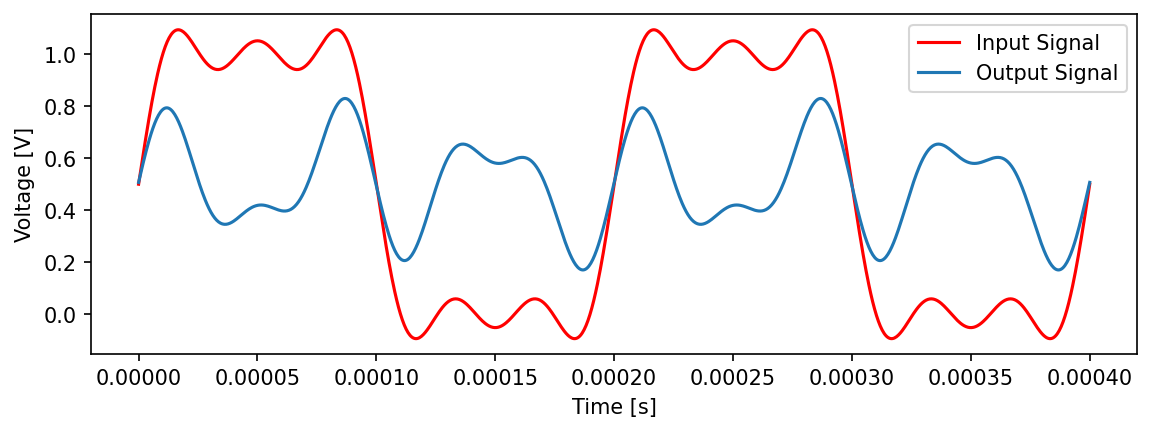

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)
T0 = 2 * 10**(-4)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

# Functions to find square wave fourier terms
SwaveFrq = lambda n : (2*n-1)*2*np.pi/T0
SwaveAmp = lambda n : 2/(np.pi * (2*n-1))
Swaveterm = lambda n,t : SwaveAmp(n) * np.sin(SwaveFrq(n)*t)

# Function to evaluate transfer function
transferF = lambda s: np.polyval(numerator, s) / np.polyval(denominator, s)

# Create dataframe with information about terms
nterms = 5

df = pd.DataFrame({'w_i' : (SwaveFrq(i) for i in range(1, nterms + 1)),
                   'f_i' : (SwaveFrq(i)/(2*np.pi) for i in range(1, nterms + 1)),
                   'A_i' : (SwaveAmp(i) for i in range(1, nterms + 1)),
                   'M_i': (np.absolute(transferF(1j*SwaveFrq(i))) for i in range(1, nterms + 1)),
                   'A_o': (SwaveAmp(i)*np.absolute(transferF(1j*SwaveFrq(i))) for i in range(1, nterms + 1)),
                   'B_i' : (np.angle(transferF(1j*SwaveFrq(i)), deg=False) for i in range(1, nterms + 1))},
                   index=[i for i in range(1, nterms + 1)])
#print(df)

# Preparing for plots
nTerms = 300
maxTime = 0.0004

InSine = lambda n, t : SwaveAmp(n) * np.sin(SwaveFrq(n) * t)
OutSine = lambda n, t : SwaveAmp(n) * np.absolute(transferF(1j*SwaveFrq(n))) * np.sin(SwaveFrq(n) * t + np.angle(transferF(1j*SwaveFrq(n)), deg=False))

tInput = np.linspace(0,maxTime,1000)

# Plotting
plt.figure(figsize=(9, 3), dpi=150)

plt.plot(tInput, 0.5 + sum((InSine(k,tInput) for k in range(1,nTerms+1))), 'r', label='Input Signal')
plt.plot(tInput, 0.5 + sum((OutSine(k,tInput) for k in range(1,nTerms+1))), label='Output Signal')

plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
#plt.grid()
plt.show()